
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [41]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [46]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [17]:
# ha['sex'] = ha['sex'].astype('object')
# ha['restecg'] = ha['restecg'].astype('object')
# ha['output'] = ha['output'].astype('object')
# ha['cp'] = ha['cp'].astype('int')

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


KNN

In [47]:
ct_pre = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [49]:
X = ha.drop(columns = "cp", axis =1)
y = ha["cp"]

knn_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('knn', KNeighborsClassifier())]
)

fitted_knn = knn_pipeline.fit(X, y)

param_grid = {
    'knn__n_neighbors': list(range(1, 100)),  # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weight function
    'knn__metric': ['euclidean', 'manhattan']  # Distance metric
}

gscv = GridSearchCV(knn_pipeline, param_grid, cv=strat_cv, scoring='roc_auc_ovr', n_jobs=-1)

# Fit the grid search
gscv_fitted = gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best ROC AUC Score:", gscv_fitted.best_score_)



Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 89, 'knn__weights': 'distance'}
Best Accuracy Score: 0.7055840024700508


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Decision Tree

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pytho

0    0.575219
Name: 1, dtype: float64


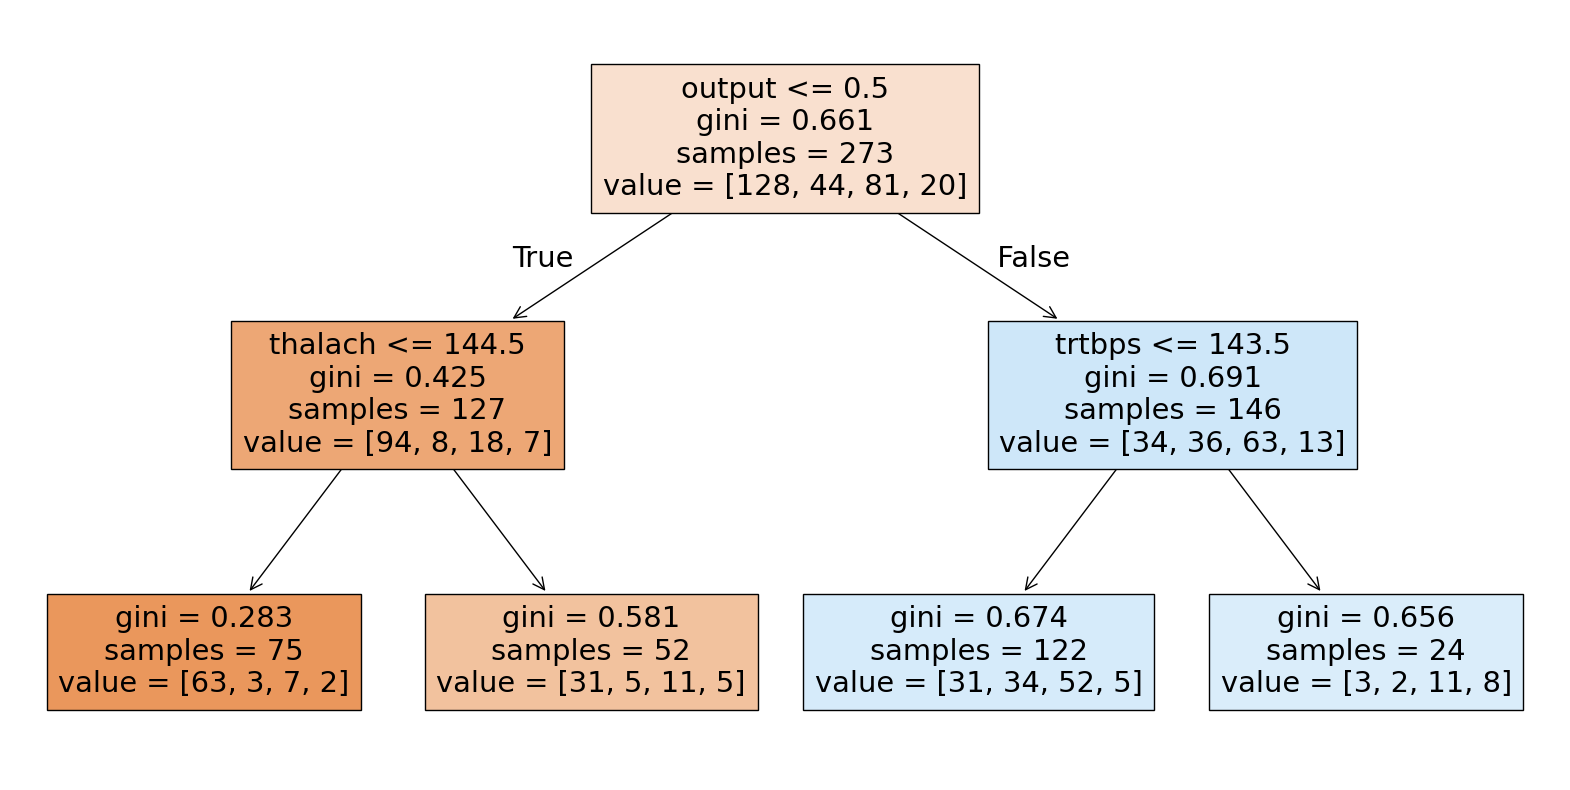

In [73]:
X = ha.drop(columns = ["cp", "cp_is_3"], axis = 1)
y = ha["cp"]

pipeline = Pipeline(
    [
     ("DT", DecisionTreeClassifier())]
)

degrees = {'DT__max_depth': list(range(0, 50))}

gscv = GridSearchCV(pipeline, degrees, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

scores = gscv_fitted.cv_results_['mean_test_score']

reshape_scores = scores.reshape(-1,50)

df = pd.DataFrame(reshape_scores)

print(df[df.max().idxmax()])


plt.figure(figsize=(20,10))
plot_tree(DecisionTreeClassifier(max_depth=2).fit(X,y), filled= True, feature_names = X.columns.to_list())
plt.show()

The first split of this decision tree depends on if the predicted probability of 'output' is above or below 0.5. If they are more than 50% likely to be at risk for heart attack, then the next split goes to whether or not the individual has a max exercise heart rate of 144.5, and if they are not at risk, the tree determines what your chest pain is given if your blood pressure is above or below 143.5.

LDA

In [70]:
X = ha.drop(columns = ["cp", "cp_is_3"], axis = 1)
y = ha["cp"]

lda_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('lda', LinearDiscriminantAnalysis())]
)

# Define parameter grid for LDA
param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],  # Solver options
    'lda__shrinkage': [None, 'auto', 0.1, 0.5, 1.0],  # Shrinkage (only for lsqr or eigen solvers)
}

fitted_lda = lda_pipeline.fit(X, y)

gscv = GridSearchCV(lda_pipeline, param_grid, cv=5, scoring='roc_auc_ovr', n_jobs=-1)

# Fit the grid search
gscv.fit(X, y)

# Extract the best parameters and scores
print("Best Parameters:", gscv_fitted.best_params_)
print("Best ROC AUC Score:", gscv_fitted.best_score_)

Best Parameters: {'dt__max_depth': None, 'dt__min_impurity_decrease': 0.05}
Best Accuracy Score: 0.6658788179191741


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [71]:
ha['cp_is_3'] = np.where(ha['cp'] == 3, 1, 0)
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3
0,63,1,3,145,233,0,150,1,1
1,37,1,2,130,250,1,187,1,0
2,56,1,1,120,236,1,178,1,0
3,57,0,0,120,354,1,163,1,0
4,57,1,0,140,192,1,148,1,0
...,...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0,0
269,57,0,0,140,241,1,123,0,0
270,45,1,3,110,264,1,132,0,1
271,68,1,0,144,193,1,141,0,0


3 vs rest

In [108]:
X = ha.drop(columns = ["cp", "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha["cp_is_3"]

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet'))]
)

degrees = {'logit__l1_ratio': list(np.arange(0.1,1, 0.1)), 'logit__C': [0.001, 0.01, 0.1, 1 ,10, 100]}

gscv = GridSearchCV(logit_pipeline, degrees, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

scores = gscv_fitted.cv_results_['mean_test_score']

reshape_scores = scores.reshape(-1,9)

df = pd.DataFrame(reshape_scores)
df
print(df.max().idxmax())
print(df[df.max().idxmax()].idxmax())
print(df.iloc[df[df.max().idxmax()].idxmax(), df.max().idxmax()])
# best l1_ratio is 0.1, best C value is 10

0
4
0.6374509803921569


In [120]:
X = ha.drop(columns = ["cp", "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha["cp_is_3"]

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio=0.1, C=10))]
)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(logit_pipeline, X, y, cv=strat_cv, scoring='f1')

print("3 vs Rest F1:", f1_scores.mean())

3 vs Rest F1: 0.0


2 vs rest

In [86]:
ha['cp_is_2'] = np.where(ha['cp'] == 2, 1, 0)
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2
0,63,1,3,145,233,0,150,1,1,0
1,37,1,2,130,250,1,187,1,0,1
2,56,1,1,120,236,1,178,1,0,0
3,57,0,0,120,354,1,163,1,0,0
4,57,1,0,140,192,1,148,1,0,0
...,...,...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0,0,0
269,57,0,0,140,241,1,123,0,0,0
270,45,1,3,110,264,1,132,0,1,0
271,68,1,0,144,193,1,141,0,0,0


In [122]:
X = ha.drop(columns = ["cp", "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha["cp_is_2"]

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio=0.1, C=10))]
)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(logit_pipeline, X, y, cv=strat_cv, scoring='f1')

print("2 vs Rest F1:",f1_scores.mean())

2 vs Rest F1: 0.09570332480818415


1 vs rest

In [113]:
ha['cp_is_1'] = np.where(ha['cp'] == 1, 1, 0)
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,3,145,233,0,150,1,1,0,0,0
1,37,1,2,130,250,1,187,1,0,1,0,0
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0,0,0,0,1
269,57,0,0,140,241,1,123,0,0,0,0,1
270,45,1,3,110,264,1,132,0,1,0,0,0
271,68,1,0,144,193,1,141,0,0,0,0,1


In [123]:
X = ha.drop(columns = ["cp", "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha["cp_is_1"]

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio=0.1, C=10))]
)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(logit_pipeline, X, y, cv=strat_cv, scoring='f1')

print("1 vs Rest F1:",f1_scores.mean())

1 vs Rest F1: 0.0


0 vs rest

In [91]:
ha['cp_is_0'] = np.where(ha['cp'] == 0, 1, 0)
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,3,145,233,0,150,1,1,0,0,0
1,37,1,2,130,250,1,187,1,0,1,0,0
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0,0,0,0,1
269,57,0,0,140,241,1,123,0,0,0,0,1
270,45,1,3,110,264,1,132,0,1,0,0,0
271,68,1,0,144,193,1,141,0,0,0,0,1


In [124]:
X = ha.drop(columns = ["cp", "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha["cp_is_0"]

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio=0.1, C=10))]
)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(logit_pipeline, X, y, cv=strat_cv, scoring='f1')

print("0 vs Rest F1:",f1_scores.mean())

0 vs Rest F1: 0.7328831685052823


The OvR approach was best at distinguising the "cp_is_0", proabably because that category had the most observations.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [125]:
ha01 = ha[ha['cp'].isin([0,1])]

ha02 = ha[ha['cp'].isin([0,2])]

ha03 = ha[ha['cp'].isin([0,3])]

In [126]:
ha01

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1
5,56,0,1,140,294,0,153,1,0,0,1,0
6,44,1,1,120,263,1,173,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
267,63,0,0,124,197,1,136,0,0,0,0,1
268,59,1,0,164,176,0,90,0,0,0,0,1
269,57,0,0,140,241,1,123,0,0,0,0,1
271,68,1,0,144,193,1,141,0,0,0,0,1


0 vs 1

In [127]:
X = ha01.drop(columns=['cp', "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha01['cp']

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio=0.1, C=10))]
)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(logit_pipeline, X, y, cv=strat_cv, scoring='roc_auc')

print("0 vs 1 ROC AUC:", scores.mean())

0 vs 3 ROC AUC: 0.8191965811965811


0 vs 2

In [128]:
X = ha02.drop(columns=['cp', "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha02['cp']

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio=0.1, C=10))]
)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(logit_pipeline, X, y, cv=strat_cv, scoring='roc_auc')

print("0 vs 2 ROC AUC:", scores.mean())

0 vs 2 ROC AUC: 0.7401402714932126


0 vs 3

In [130]:
X = ha03.drop(columns=['cp', "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis = 1)
y = ha03['cp']

logit_pipeline = Pipeline(
    [('preprocessing', ct_pre),
     ('logit', LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio=0.1, C=10))]
)

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(logit_pipeline, X, y, cv=strat_cv, scoring='roc_auc')

print("0 vs 3 ROC AUC:", scores.mean())

0 vs 3 ROC AUC: 0.723923076923077


The OvO approach was best at distinguishing the pair comparing 0 and 1, this is likely due to a cp of class 1 being the most frequent in the data set.